In [ ]:
import torch
import torchvision
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split
from torchvision.models import resnet50, ResNet50_Weights,resnet18, ResNet18_Weights
import torch.nn as nn
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from prettytable import PrettyTable

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


Downlaod and show randomly data of each type

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,  download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
batch_size = 64
trainloader = DataLoader(trainset, batch_size=batch_size,  shuffle=True )
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

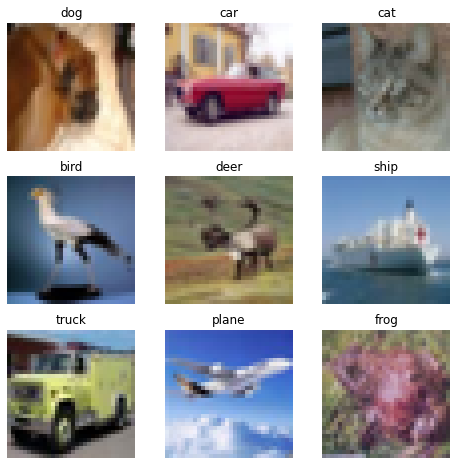

In [ ]:
labels_map = {
    0: 'plane',
    1: 'car',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
lab = set()
while(len(lab) <= 8):
  sample_idx = torch.randint(len(trainset), size=(1,)).item()
  img, label = trainset[sample_idx]
  if label not in lab:
    lab.add(label)
    figure.add_subplot(rows, cols, len(lab))
    plt.title(labels_map[label])
    plt.axis("off")
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()

ResNet50 Parameters

In [ ]:
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
model.to(device)

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
params = count_parameters(model)

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
|         conv1.weight         |    9408    |
|          bn1.weight          |     64     |
|           bn1.bias           |     64     |
|    layer1.0.conv1.weight     |    4096    |
|     layer1.0.bn1.weight      |     64     |
|      layer1.0.bn1.bias       |     64     |
|    layer1.0.conv2.weight     |   36864    |
|     layer1.0.bn2.weight      |     64     |
|      layer1.0.bn2.bias       |     64     |
|    layer1.0.conv3.weight     |   16384    |
|     layer1.0.bn3.weight      |    256     |
|      layer1.0.bn3.bias       |    256     |
| layer1.0.downsample.0.weight |   16384    |
| layer1.0.downsample.1.weight |    256     |
|  layer1.0.downsample.1.bias  |    256     |
|    layer1.1.conv1.weight     |   16384    |
|     layer1.1.bn1.weight      |     64     |
|      layer1.1.bn1.bias       |     64     |
|    layer1.1.conv2.weight     |  

Freeze ResNet50 Parameters Except Last Layer

In [ ]:
for name, parameter in model.named_parameters():
  if name =='fc.weight' or name =='fc.bias':
    continue
  parameter.requires_grad = False
for name, layer in model.named_modules():
    if name =='fc':
        model._modules[name] = torch.nn.Linear(2048, 10)

In [ ]:
count_parameters(model)

+-----------+------------+
|  Modules  | Parameters |
+-----------+------------+
| fc.weight |   20480    |
|  fc.bias  |     10     |
+-----------+------------+
Total Trainable Params: 20490


20490

Train and test and distillation_train fuctioin

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        model.train()
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            model.eval()
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

def distillation_train(dataloader, model1, model, alpha, temp, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            model.eval()
            pred = model(X)
        model1.train()
        pred1 = model1(X)
        loss = (1-alpha)*loss_fn(pred, y) + (alpha)*loss_fn(pred1/temp,torch.exp(nn.functional.log_softmax(pred/temp,dim=1)))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
epochs = 5
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

test_accuracy = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, model, loss_fn, optimizer)
    test_accuracy.append(test(testloader, model, loss_fn))

    if t>0:
       if test_accuracy[t-1]<=test_accuracy[t]:
         torch.save(model, '/content/drive/MyDrive/HW3/ResNet50_Model_CIFAR10_Dataset.pth')
      
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 46.6%, Avg loss: 1.689136 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 47.4%, Avg loss: 1.905352 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 47.7%, Avg loss: 1.647621 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 47.6%, Avg loss: 1.823031 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 46.4%, Avg loss: 1.828684 

Done!


Training ResNet18 with ResNet50

In [ ]:
weights1 = ResNet18_Weights.DEFAULT
model1 = resnet18(weights=weights1)

count_parameters(model1)

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
|         conv1.weight         |    9408    |
|          bn1.weight          |     64     |
|           bn1.bias           |     64     |
|    layer1.0.conv1.weight     |   36864    |
|     layer1.0.bn1.weight      |     64     |
|      layer1.0.bn1.bias       |     64     |
|    layer1.0.conv2.weight     |   36864    |
|     layer1.0.bn2.weight      |     64     |
|      layer1.0.bn2.bias       |     64     |
|    layer1.1.conv1.weight     |   36864    |
|     layer1.1.bn1.weight      |     64     |
|      layer1.1.bn1.bias       |     64     |
|    layer1.1.conv2.weight     |   36864    |
|     layer1.1.bn2.weight      |     64     |
|      layer1.1.bn2.bias       |     64     |
|    layer2.0.conv1.weight     |   73728    |
|     layer2.0.bn1.weight      |    128     |
|      layer2.0.bn1.bias       |    128     |
|    layer2.0.conv2.weight     |  

11689512

In [ ]:
for name, layer in model1.named_modules():
    if name =='fc':
        model1._modules[name] = torch.nn.Linear(512, 10)

Finding The Best Distillation Hyperparameters in 2 epochs

In [ ]:
loss_fn = nn.CrossEntropyLoss()
epochs = 2

model1.to(device)

teacher_model = torch.load('/content/drive/MyDrive/HW3/ResNet50_Model_CIFAR10_Dataset.pth')
teacher_model.to(device)

test_accuracy1 = []
alphas =[0.5, 0.8, 1]
temps =[1, 10, 20]

for alpha in alphas:
  for temp in temps:
      student_model = model1
      optimizer = torch.optim.Adam(student_model.parameters(), lr = 1e-3)
      
      for t in range(epochs):
          print(f"Epoch {t+1}\n-------------------------------")
          distillation_train(trainloader,student_model,teacher_model,alpha,temp,loss_fn, optimizer)
          test_accuracy1.append(test(testloader,student_model, loss_fn))

          if np.argmax(test_accuracy1) == len(test_accuracy1)-1:
              main_alpha = alpha
              main_temp = temp
              torch.save(student_model,'/content/drive/MyDrive/HW3/ResNet18_Distillation_Model_CIFAR10_Dataset.pth')
            
      print("Done!")

print(f'The best alpha is:{main_alpha}')
print(f'The best temperture is:{main_temp}')

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 58.7%, Avg loss: 1.422011 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.470450 

Done!
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.325578 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 60.2%, Avg loss: 1.387073 

Done!
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 61.7%, Avg loss: 1.230205 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 61.7%, Avg loss: 1.345466 

Done!
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 62.9%, Avg loss: 1.479615 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 63.0%, Avg loss: 1.355564 

Done!
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 63.2%, Avg loss: 1.231613 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 61.6%, Avg loss: 1.371505 

Done!
Epoch 1
-------------------------------
Test Error

Training Student Model With Best Hyperparameters in 5 Epochs

In [ ]:
loss_fn = nn.CrossEntropyLoss()
epochs = 5 

teacher_model = torch.load('/content/drive/MyDrive/HW3/ResNet50_Model_CIFAR10_Dataset.pth')
teacher_model.to(device)

test_accuracy1 = [np.max(test_accuracy1)]

student_model = torch.load('/content/drive/MyDrive/HW3/ResNet18_Distillation_Model_CIFAR10_Dataset.pth')
student_model.to(device)

for t in range(epochs):
          print(f"Epoch {t+3}\n-------------------------------")
          distillation_train(trainloader, student_model, teacher_model, main_alpha , main_temp, loss_fn, optimizer)
          test_accuracy1.append(test(testloader,student_model, loss_fn))
          if np.argmax(test_accuracy1)==len(test_accuracy1)-1:
              torch.save(student_model,'/content/drive/MyDrive/HW3/ResNet18_Distillation_Model_CIFAR10_Dataset.pth')   
print("Done!")

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 63.2%, Avg loss: 1.228356 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 62.9%, Avg loss: 1.255212 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 62.7%, Avg loss: 1.264652 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 62.8%, Avg loss: 1.294492 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 63.3%, Avg loss: 1.242582 

Done!



Training ResNet18 On CIFAR10 Without Teacher

In [ ]:
epochs = 5
model1.to(device)
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-3)
test_accuracy2 = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, model1, loss_fn, optimizer)
    test_accuracy2.append(test(testloader, model1, loss_fn))
    if t>0:
       if test_accuracy2[t-1]<=test_accuracy2[t]:
         torch.save(model1, '/content/drive/MyDrive/HW3/ResNet18_Model_CIFAR10_Dataset.pth')
      
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 72.3%, Avg loss: 0.879512 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.692169 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 77.7%, Avg loss: 0.710438 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 78.8%, Avg loss: 0.767361 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 77.5%, Avg loss: 0.919326 

Done!


Fine Tunning of ResNet50

In [ ]:
weights2 = ResNet50_Weights.DEFAULT
model2 = resnet50(weights=weights2)
count_parameters(model2)

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
|         conv1.weight         |    9408    |
|          bn1.weight          |     64     |
|           bn1.bias           |     64     |
|    layer1.0.conv1.weight     |    4096    |
|     layer1.0.bn1.weight      |     64     |
|      layer1.0.bn1.bias       |     64     |
|    layer1.0.conv2.weight     |   36864    |
|     layer1.0.bn2.weight      |     64     |
|      layer1.0.bn2.bias       |     64     |
|    layer1.0.conv3.weight     |   16384    |
|     layer1.0.bn3.weight      |    256     |
|      layer1.0.bn3.bias       |    256     |
| layer1.0.downsample.0.weight |   16384    |
| layer1.0.downsample.1.weight |    256     |
|  layer1.0.downsample.1.bias  |    256     |
|    layer1.1.conv1.weight     |   16384    |
|     layer1.1.bn1.weight      |     64     |
|      layer1.1.bn1.bias       |     64     |
|    layer1.1.conv2.weight     |  

25557032

In [ ]:
for name, parameter in model2.named_parameters():
  if name =='layer2.0.conv1.weight':
    break
  parameter.requires_grad = False
for name, layer in model2.named_modules():
    if name =='fc':
        model2._modules[name] = torch.nn.Linear(2048, 10)

count_parameters(model2)

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
|    layer2.0.conv1.weight     |   32768    |
|     layer2.0.bn1.weight      |    128     |
|      layer2.0.bn1.bias       |    128     |
|    layer2.0.conv2.weight     |   147456   |
|     layer2.0.bn2.weight      |    128     |
|      layer2.0.bn2.bias       |    128     |
|    layer2.0.conv3.weight     |   65536    |
|     layer2.0.bn3.weight      |    512     |
|      layer2.0.bn3.bias       |    512     |
| layer2.0.downsample.0.weight |   131072   |
| layer2.0.downsample.1.weight |    512     |
|  layer2.0.downsample.1.bias  |    512     |
|    layer2.1.conv1.weight     |   65536    |
|     layer2.1.bn1.weight      |    128     |
|      layer2.1.bn1.bias       |    128     |
|    layer2.1.conv2.weight     |   147456   |
|     layer2.1.bn2.weight      |    128     |
|      layer2.1.bn2.bias       |    128     |
|    layer2.1.conv3.weight     |  

23303178

In [ ]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
epochs = 5
model2.to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)
test_accuracy3 = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, model2, loss_fn, optimizer)
    test_accuracy3.append(test(testloader, model2, loss_fn))
    if t>0:
       if test_accuracy3[t-1]<=test_accuracy3[t]:
         torch.save(model2, '/content/drive/MyDrive/HW3/ResNet50_Fine_Tuned_Model_CIFAR10_Dataset.pth')
      
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 81.1%, Avg loss: 0.593228 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 83.8%, Avg loss: 0.498783 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 83.1%, Avg loss: 0.530996 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 85.4%, Avg loss: 0.476586 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 84.8%, Avg loss: 0.514541 

Done!
